In [1]:
!date

Wed Mar  4 18:32:53 PST 2020


# Make 10x gene matrix and perform cluster comparison

In [2]:
import anndata
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as scanp
from scipy.stats import ks_2samp, ttest_ind
from scipy import stats
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [18]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [4]:
path = "/home/sina/projects/mop/mop_10xv3"
file_paths = glob.glob(path + "/gene_out*/counts_filtered/adata.h5ad")

In [5]:
file_paths = np.sort(file_paths).tolist()

In [6]:
file_paths

['/home/sina/projects/mop/mop_10xv3/gene_out_L8TX_181211_01_A01_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_10xv3/gene_out_L8TX_181211_01_B01_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_10xv3/gene_out_L8TX_181211_01_C01_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_10xv3/gene_out_L8TX_181211_01_D01_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_10xv3/gene_out_L8TX_181211_01_E01_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_10xv3/gene_out_L8TX_181211_01_F01_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_10xv3/gene_out_L8TX_181211_01_G12_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_10xv3/gene_out_L8TX_181211_01_H12_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_10xv3/gene_out_L8TX_190430_01_A08_S01_L003/counts_filtered/adata.h5ad',
 '/home/sina/projects/mop/mop_10xv3/gene_out_L8TX_190430_01_B08_S01_L003/counts_fi

In [7]:
batch_id = [
"3L8TX_181211_01_A01",
"4L8TX_181211_01_B01",
"5L8TX_181211_01_C01",
"6L8TX_181211_01_D01",
"7L8TX_181211_01_E01",
"8L8TX_181211_01_F01",
"1L8TX_181211_01_G12",
"2L8TX_181211_01_H12",
"9L8TX_190430_01_A08",    
"10L8TX_190430_01_B08",
"11L8TX_190430_01_F08",    
"12L8TX_190430_01_G08"]

In [8]:
%%time
files = []
for fidx, f in enumerate(file_paths):
    print("{} of {}".format(fidx+1, len(file_paths)))
    files.append(anndata.read_h5ad(f))

1 of 12
2 of 12
3 of 12
4 of 12
5 of 12
6 of 12
7 of 12
8 of 12
9 of 12
10 of 12
11 of 12
12 of 12
CPU times: user 1.31 s, sys: 2.69 s, total: 3.99 s
Wall time: 3.98 s


In [9]:
adata = files[0].concatenate(*files[1:], batch_categories=batch_id)

In [10]:
adata

AnnData object with n_obs × n_vars = 169200 × 31053 
    obs: 'batch'
    var: 'gene_name'

In [11]:
adata.obs.head()

,batch
AAACCCAAGGTGTGAC-3L8TX_181211_01_A01,3L8TX_181211_01_A01
AAACCCAAGTTGGACG-3L8TX_181211_01_A01,3L8TX_181211_01_A01
AAACCCACACAAACGG-3L8TX_181211_01_A01,3L8TX_181211_01_A01
AAACCCACAGACACAG-3L8TX_181211_01_A01,3L8TX_181211_01_A01
AAACCCACAGCGCTTG-3L8TX_181211_01_A01,3L8TX_181211_01_A01


In [12]:
ca = pd.read_csv("/home/sina/projects/mop/mop_10xv3/dropbox/cluster.annotation.csv", index_col=0)
cm = pd.read_csv("/home/sina/projects/mop/mop_10xv3/dropbox/cluster.membership.csv", index_col=0)

In [13]:
adata = adata[adata.obs.index.isin(cm.index)]

In [14]:
adata.obs["cluster_id"] = adata.obs.index.map(cm["x"])

Trying to set attribute `.obs` of view, copying.


In [15]:
adata.obs["cluster_label"]  = adata.obs["cluster_id"].map(ca["cluster_label"])
adata.obs["subclass_label"] = adata.obs["cluster_id"].map(ca["subclass_label"])
adata.obs["class_label"]    = adata.obs["cluster_id"].map(ca["class_label"])

In [16]:
le = LabelEncoder()
adata.obs["cluster_id"] = le.fit_transform(adata.obs.cluster_label.values)

le = LabelEncoder()
adata.obs["subclass_id"] = le.fit_transform(adata.obs.subclass_label.values)

le = LabelEncoder()
adata.obs["class_id"] = le.fit_transform(adata.obs.class_label.values)

In [17]:
adata.obs.cluster_label.nunique()

147

In [18]:
adata

AnnData object with n_obs × n_vars = 94162 × 31053 
    obs: 'batch', 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'subclass_id', 'class_id'
    var: 'gene_name'

In [19]:
adata.var["gene_id"] = adata.var.index.str.slice(0,18).values
adata.var["gene_short_name"] = adata.var["gene_name"]
adata.var["gene_name"] = adata.var["gene_short_name"] + "_"+ adata.var['gene_id']

In [20]:
adata.var.index = adata.var["gene_name"].values

In [5]:
def change(x):
    if x=="L5 ET": return "L5 PT"
    return x

In [6]:
adata.obs.subclass_label.value_counts()

L5 IT          29721
Low Quality    22728
L6 CT          12807
L2/3 IT        10915
L6 IT           4445
L5/6 NP         3147
Vip             2966
Lamp5           2357
Sst             1869
L6b              554
Oligo            535
Astro            395
Pvalb            368
Sncg             348
doublet          257
Endo             187
L5 ET            161
OPC              145
Macrophage       122
L6 IT Car3        69
VLMC              55
SMC               11
Name: subclass_label, dtype: int64

In [7]:
adata.obs.cluster_label = adata.obs.cluster_label.apply(change).values
adata.obs.subclass_label = adata.obs.subclass_label.apply(change).values

In [73]:
adata.obs.subclass_label.value_counts()

L5 IT          29721
Low Quality    22728
L6 CT          12807
L2/3 IT        10915
L6 IT           4445
L5/6 NP         3147
Vip             2966
Lamp5           2357
Sst             1869
L6b              554
Oligo            535
Astro            395
Pvalb            368
Sncg             348
doublet          257
Endo             187
L5 PT            161
OPC              145
Macrophage       122
L6 IT Car3        69
VLMC              55
SMC               11
Name: subclass_label, dtype: int64

In [74]:
adata.write_h5ad("../cell_ranger_annotation/10xv3_gene.h5ad")

In [75]:
adata

View of AnnData object with n_obs × n_vars = 94162 × 31053 
    obs: 'batch', 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'subclass_id', 'class_id'
    var: 'gene_name', 'gene_id', 'gene_short_name'

In [4]:
adata = anndata.read_h5ad("../cell_ranger_annotation/10xv3_gene.h5ad")

In [9]:
ss = anndata.read_h5ad("../cell_ranger_annotation/gene.h5ad")

In [10]:
ss = ss[:,ss.var.sort_index().index]
adata = adata[:,adata.var.sort_index().index]

In [11]:
ss = ss[:,ss.var.sort_index().index]

In [12]:
tenx = adata[:,adata.var.index.isin(ss.var.index)]

In [13]:
tenx = tenx[:,tenx.var.sort_index().index]

In [14]:
print(ss)
print(tenx)

View of AnnData object with n_obs × n_vars = 6160 × 19190 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_counts', 'percent_mito', 'n_genes', 'pass_count_filter', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'txn_list', 'num_isoforms', 'gene_counts', 'dispersion', 'pass_disp_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p', 'norm'
View of AnnData object with n_obs × n_vars = 94162 × 19190 
    obs: 'batch', 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'subclass_id', 'class_id'
    var: 'gene_name', 'gene_id', 'gene_short_name'


In [28]:
adata.obs["subclass_label"].value_counts()

L5 IT          29721
Low Quality    22728
L6 CT          12807
L2/3 IT        10915
L6 IT           4445
L5/6 NP         3147
Vip             2966
Lamp5           2357
Sst             1869
L6b              554
Oligo            535
Astro            395
Pvalb            368
Sncg             348
doublet          257
Endo             187
L5 PT            161
OPC              145
Macrophage       122
L6 IT Car3        69
VLMC              55
SMC               11
Name: subclass_label, dtype: int64

In [25]:
ss.obs["subclass_label"].value_counts()

L5 IT          1561
L6 CT           904
Vip             607
L6b             570
Pvalb           521
L2/3 IT         482
Sst             406
L6 IT           395
Lamp5           360
L5/6 NP         207
Sncg             77
SMC              19
L5 PT            12
Low Quality      12
Astro             9
Endo              7
VLMC              6
L6 IT Car3        5
Name: subclass_label, dtype: int64

# Number of cells per cluster

In [15]:
tenx.obs["cell_id"] = tenx.obs.index.values

Trying to set attribute `.obs` of view, copying.


In [19]:
cluster_cmap["doublet"] = (0.4588235294117647,  0.4196078431372549,  0.6941176470588235  )  # 756bb1
cluster_cmap["Macrophage"] =     (0.6196078431372549,  0.6039215686274509,  0.7843137254901961  )  # 9e9ac8
cluster_cmap["OPC"] =     (0.7372549019607844,  0.7411764705882353,  0.8627450980392157  )  # bcbddc
cluster_cmap["Oligo"] =     (0.8549019607843137,  0.8549019607843137,  0.9215686274509803  )  # dadaeb

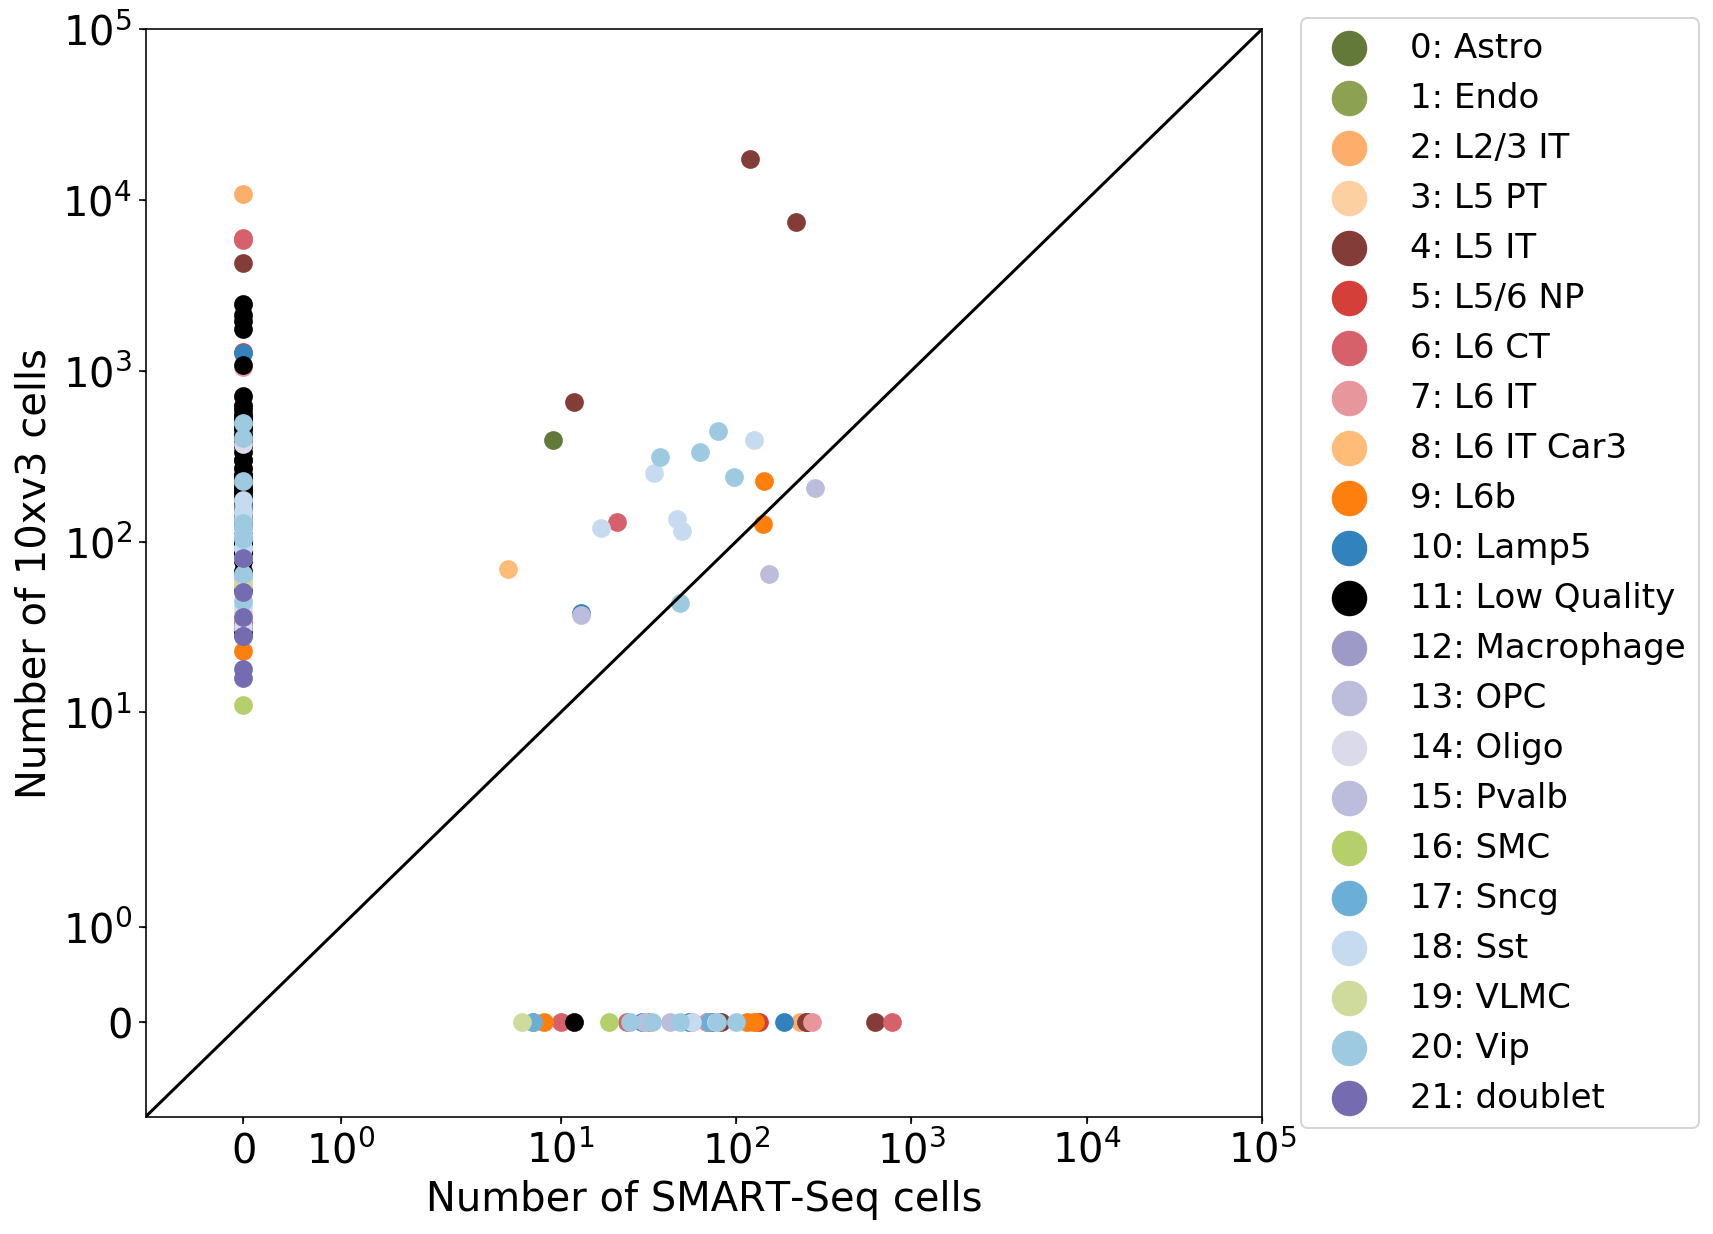

In [72]:
fig, ax = plt.subplots(figsize=(10,10))

ss_labels = ss.obs.groupby("subclass_label").count()["cell_id"].index
tenx_labels = tenx.obs.groupby("subclass_label").count()["cell_id"].index

size=70
for lidx, l in enumerate(tenx_labels):
    if l not in ss_labels:

        y = tenx[tenx.obs["subclass_label"] == l].obs["cluster_label"].value_counts()
        x = np.zeros_like(y)
        
        ax.scatter(x, y, color = cluster_cmap[l], label="{}: {}".format(lidx, l), s=size)
    else: 
            
        x = ss[ss.obs["subclass_label"] == l].obs["cluster_label"].value_counts()
        y = tenx[tenx.obs["subclass_label"] == l].obs["cluster_label"].value_counts()
        union = np.union1d(x.index, y.index)
        
        x_idx = [np.where(union==i)[0][0] for i in x.index]
        y_idx = [np.where(union==i)[0][0] for i in y.index]
        
        xx = np.zeros_like(union)
        xx[x_idx] = x.values
        
        yy = np.zeros_like(union)
        yy[y_idx] = y.values
        
        ax.scatter(xx, yy, color=cluster_cmap[l], label="{}: {}".format(lidx, l), s=size)
        
        
        
ax.plot([-1,10**5], [-1,10**5], color="k")
ax.set_yscale('symlog')
ax.set_xscale('symlog')


ax.set_xlim(-1, 10**5)
ax.set_ylim(-1, 10**5)


ax.legend(loc="center left", bbox_to_anchor=(1.02,0.5), markerscale=2, fontsize=17)

ax.set_xlabel("Number of SMART-Seq cells")
ax.set_ylabel("Number of 10xv3 cells")
plt.savefig("./figures/10x_ss_celltypes.png", bbox_inches='tight',dpi=300)

plt.show()

In [27]:
y

Ex Inh                80
Lamp5 doublet         51
Endo Slc38a5_5        36
L6 IT Car3_Inh        28
Ex Endo               28
Endo_VLMC             18
Oligo Opalin_neuon    16
Name: cluster_label, dtype: int64

In [29]:
tenx_cluster = np.unique(tenx.obs.cluster_label)
ss_cluster = np.unique(ss.obs.cluster_label)

union = np.union1d(tenx_cluster, ss_cluster)

In [60]:
x = np.zeros_like(union)
y = np.zeros_like(union)

# Verifying the above is right

## Populate x with cluster values from smart-seq

In [61]:
ind = ss.obs.cluster_label.value_counts().index
val = ss.obs.cluster_label.value_counts().values

In [62]:
index = np.array([np.where(union==i)[0][0] for i in ind])
x[index] = val

## Populate y with clusters from 10xv3

In [63]:
ind = tenx.obs.cluster_label.value_counts().index
val = tenx.obs.cluster_label.value_counts().values

In [64]:
index = np.array([np.where(union==i)[0][0] for i in ind])
y[index] = val

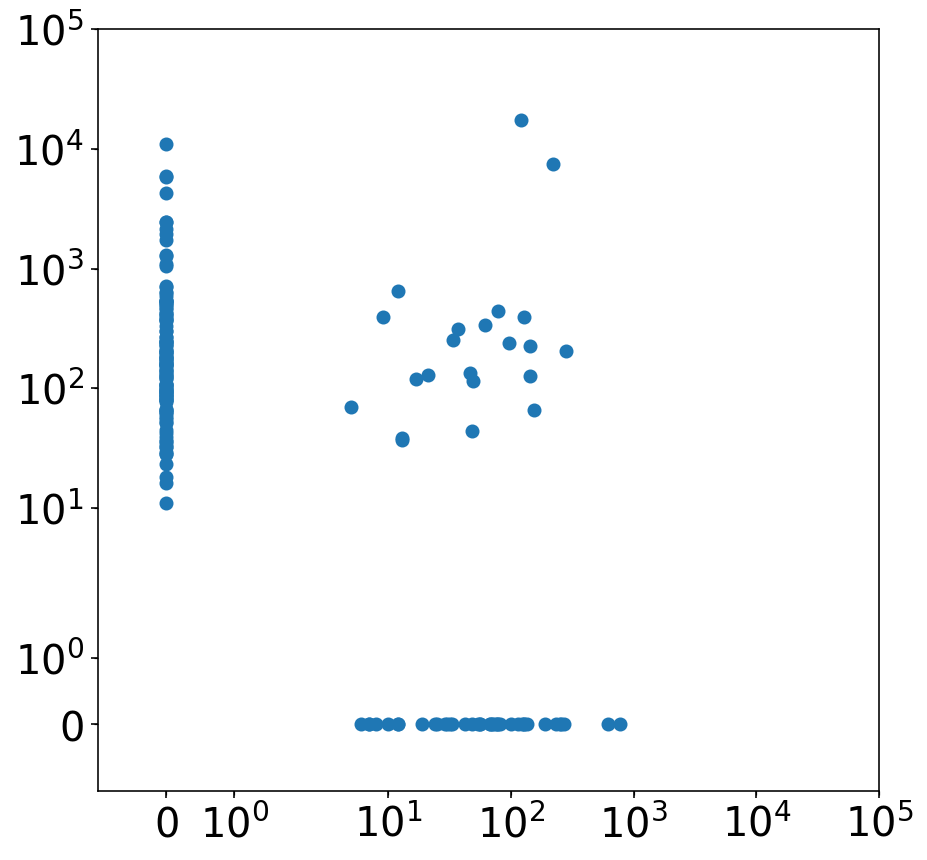

In [65]:
fig, ax = plt.subplots(figsize=(7,7))

ax.scatter(x,y)
ax.set_yscale('symlog')
ax.set_xscale('symlog')


ax.set_xlim(-1, 10**5)
ax.set_ylim(-1, 10**5)
plt.show()

In [66]:
diff = np.setdiff1d(ss.obs.cluster_label, tenx.obs.cluster_label)

In [67]:
diff.shape

(40,)

In [68]:
diff

array(['Endo Slc38a5', 'L2/3 IT Cdh13 Sla', 'L2/3 IT Macc1',
       'L2/3 IT S100a6', 'L5 IT Rspo1', 'L5 IT Rspo2', 'L5 IT S100b_1',
       'L5 IT S100b_2', 'L5 IT Tcap_low', 'L5 NP Slc17a8', 'L5 PT',
       'L6 CT Grp_1', 'L6 CT Grp_2', 'L6 CT Nxph2_1', 'L6 CT Nxph2_2',
       'L6 IT Sulf_1', 'L6 IT Sulf_2', 'L6 IT Sulf_3', 'L6 NP Trh',
       'L6b Kcnip1_1', 'L6b Kcnip1_2', 'L6b Ror1_1', 'L6b Ror1_2',
       'Lamp5 Egln3_1', 'Lamp5 Egln3_2', 'Lamp5 Pdlim5', 'Lamp5 Slc35d3',
       'Pvalb Gpr149', 'Pvalb Th', 'SMC Aoc3', 'Sncg', 'Sncg Slc17a8',
       'Sst C1ql3', 'Sst Etv1', 'VLMC', 'Vip Chat_1', 'Vip Chat_2',
       'Vip Chat_3', 'Vip Htr1f', 'Vip Lmo1'], dtype=object)

In [69]:
diff = np.setdiff1d(tenx.obs.cluster_label, ss.obs.cluster_label)

In [70]:
diff.shape

(125,)

In [71]:
diff

array(['Endo Slc38a5_1', 'Endo Slc38a5_5', 'Endo_VLMC', 'Ex Endo',
       'Ex Inh', 'L2/3 IT', 'L2/3 IT S100a6 _1_low',
       'L2/3 IT S100a6 _2_low', 'L2/3 IT low', 'L5 ET_1', 'L5 ET_1_low',
       'L5 ET_2', 'L5 ET_2_low', 'L5 ET_3', 'L5 IT Rspo1_1_low',
       'L5 IT Rspo1_2_low', 'L5 IT Rspo2_3_low', 'L5 IT S100b',
       'L5 IT S100b_1_low', 'L5 IT S100b_2_low', 'L5 IT S100b_3_low',
       'L5 NP Slc17a8_1', 'L5 NP Slc17a8_2', 'L5 NP Slc17a8_3',
       'L5 NP Slc17a8_low_1', 'L5 NP Slc17a8_low_2',
       'L5 NP Slc17a8_low_3', 'L6 CT Cpa6_1', 'L6 CT Cpa6_2',
       'L6 CT Cpa6_2_low', 'L6 CT Cpa6_low', 'L6 CT Nxph2 Kit',
       'L6 CT Nxph2 Pou3f2_1', 'L6 CT Nxph2 Pou3f2_2', 'L6 IT Car3_Inh',
       'L6 IT Sulf1_1', 'L6 IT Sulf1_1_low', 'L6 IT Sulf1_2',
       'L6 IT Sulf1_2_low', 'L6 IT Sulf1_3', 'L6 IT Sulf1_3_low',
       'L6 IT Sulf1_4', 'L6 IT Sulf1_4_low', 'L6 IT Sulf1_5_low',
       'L6 NP Trh_1', 'L6 NP Trh_2', 'L6 NP Trh_3', 'L6 NP Trh_Oligo',
       'L6 NP Trh_low', 'L6